<a href="https://colab.research.google.com/github/pkscanvas/Optimal-Satellite-Pose-Estimation-/blob/master/Speedv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google Drive to access the dataset.**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Importing all necessary packages.


*   The **preprocess_input** function is meant to adequate your image to the format the model requires
*  **ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).



In [2]:

dataset_root="/content/gdrive/My Drive/Colab Notebooks/speed"
import pandas as pd
import os
import json
import numpy as np
import keras
import tensorflow
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.applications.xception import preprocess_input  
from keras.models import Model
from keras.layers import Dense,Flatten,BatchNormalization,Activation,AlphaDropout
from sklearn.model_selection import train_test_split

  

Using TensorFlow backend.




1.   **with:** there is no need to call file.close() when using with statement. The with statement itself ensures proper acquisition and release of resource, it also takes care of all the exceptions by itself
2.   **os.path** contains functions for manipulating filenames and directory names.
3.**os.path.join()** function will add an extra slash to the pathname before joining it to the filename.



In [3]:
with open(os.path.join(dataset_root,'train.json'),'r') as train:
  train_json=json.load(train)
train_json[0]['q_vbs2tango']
#len(train_json)
type(train_json)
# q=train_json[i]['q_vbs2tango']
# r=train_json[i]['r_Vo2To_vbs_true']
# a=q.extend(r)


list

In [0]:
imgname_list=[]
for i in range(len(train_json)):
  imgname_list.append(train_json[i]['filename'])

#imgname_list

Putting all the images and corresponding 7 continuous values (4 from quaternion vector, 3 from position vector) in a Pandas dataframe to be able to use with **flow_from_dataframe** function
for multilabel regression.

In [0]:
label_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
  q1.append(train_json[i]['q_vbs2tango'][0])
  q2.append(train_json[i]['q_vbs2tango'][1])
  q3.append(train_json[i]['q_vbs2tango'][2])
  q4.append(train_json[i]['q_vbs2tango'][3])
  r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
  r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
  r3.append(train_json[i]['r_Vo2To_vbs_true'][2])
  #q.extend(r)
  #label_list.append(q)



In [6]:
col_dict={'image_names':imgname_list,'q1':q1,'q2':q2,'q3':q3,'q4':q4,'r1':r1,'r2':r2,'r3':r3}
df=pd.DataFrame(col_dict)
#df['labels']=label_list
df_train,df_test=train_test_split(df,test_size=0.2)
len(df_test)
df_train.head()

,image_names,q1,q2,q3,q4,r1,r2,r3
9160,img011473.jpg,-0.020454,-0.602443,-0.115613,-0.789480,0.268229,0.152553,12.250661
5908,img007390.jpg,-0.705974,0.685353,0.165028,0.068248,-0.286908,0.423627,17.662971
490,img000626.jpg,-0.988565,0.049722,0.029128,0.139353,0.440890,0.356666,23.841376
3037,img003816.jpg,-0.472931,0.182862,0.444381,0.738528,-0.064295,0.151893,5.067200
4611,img005782.jpg,0.238725,-0.540351,0.479560,-0.648886,-0.206844,-0.156809,12.987001


Previously, one should have to write a custom generator if they have to perform regression or predict multiple columns and utilize the image augmentation capabilities of the ImageDataGenerator, now we can have the target values as just another column/s (must be numerical datatype) in our dataframe, simply provide the column names to the **flow_from_dataframe** and we can now use all the augmentations provided by the ImageDataGenerator

In [7]:
path="/content/gdrive/My Drive/Colab Notebooks/speed/images/train"
cols=['q1','q2','q3','q4','r1','r2','r3']
datagen=ImageDataGenerator(preprocessing_function=preprocess_input,zoom_range=0.35,brightness_range=[0.7,1.3],) #Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.
datagen2=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(df_train,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')
validation_generator=datagen2.flow_from_dataframe(df_test,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="image_names". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9599 validated image filenames.
Found 2400 validated image filenames.


In [8]:
len(train_generator)

300

**Building our model using Transfer Learning.**

In [9]:

#tensorflow.keras.backend.set_learning_phase(0)
model_pretrained=Xception(weights='imagenet',include_top=False,input_shape=(299,299,3))
#tensorflow.keras.backend.set_learning_phase(1)

#using keras functional api to build our model

x=model_pretrained.output

#x=Flatten()(x)

#x=Dense(32,activation='selu',kernel_initializer='lecun_normal')(x)
        
#x=BatchNormalization()(x)

x=Dense(128,activation='relu',kernel_initializer='he_normal')(x) #
   
#x=AlphaDropout(0.1)(x)
        
# x=Dense(64,activation='selu',kernel_initializer='lecun_normal')(x) #
   
# x=AlphaDropout(0.1)(x)

#x=BatchNormalization()(x)
        
#x=Dense(128,activation='selu',kernel_initializer='lecun_normal')(x)
        
x=Flatten()(x)
        
x=Dense(7,activation='linear')(x)

model=Model(inputs=model_pretrained.input,outputs=x)


# step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
# step_size_valid=validation_generator.n//validation_generator.batch_size
# history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=2,validation_data=validation_generator,validation_steps=step_size_valid)


W0729 21:17:08.620064 140605397030784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 21:17:08.667516 140605397030784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 21:17:08.676252 140605397030784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 21:17:08.717149 140605397030784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0729 21:17:08.718073 1406053970

83689472/83683744 [==============================] - 2s 0us/step


**IMP** Which layers to train or not should be done before model compilation.

In [0]:
# train_generator[0][0][0][0][0]
# train_generator

In [11]:
for i,j in enumerate(model.layers):
  print(i,':',j)
for layer in model.layers[:17]:
  layer.trainable=True
for layer in model.layers[17:]:
  layer.trainable=True

0 : <keras.engine.input_layer.InputLayer object at 0x7fe0eaf35e10>
1 : <keras.layers.convolutional.Conv2D object at 0x7fe0eaf359e8>
2 : <keras.layers.normalization.BatchNormalization object at 0x7fe0eaf36080>
3 : <keras.layers.core.Activation object at 0x7fe0eaf36a58>
4 : <keras.layers.convolutional.Conv2D object at 0x7fe0dc6ebfd0>
5 : <keras.layers.normalization.BatchNormalization object at 0x7fe0dc70af60>
6 : <keras.layers.core.Activation object at 0x7fe0dc67cc88>
7 : <keras.layers.convolutional.SeparableConv2D object at 0x7fe0dc621a90>
8 : <keras.layers.normalization.BatchNormalization object at 0x7fe0dc54e6d8>
9 : <keras.layers.core.Activation object at 0x7fe0dc4dbd68>
10 : <keras.layers.convolutional.SeparableConv2D object at 0x7fe0dc49f438>
11 : <keras.layers.normalization.BatchNormalization object at 0x7fe0dc44ff98>
12 : <keras.layers.convolutional.Conv2D object at 0x7fe0dc604f98>
13 : <keras.layers.pooling.MaxPooling2D object at 0x7fe0dc3db7b8>
14 : <keras.layers.normalization.

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [13]:

sgd=keras.optimizers.sgd(lr=1e-4,decay=5e-4, momentum=0.9, nesterov=True)
adam=keras.optimizers.adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-20,mode='min',verbose=1)
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min',min_delta=0.01,restore_best_weights=True)
model.compile(optimizer=sgd,loss='mean_squared_error') #,metrics=['mse']
step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
step_size_valid=validation_generator.n//validation_generator.batch_size
history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=50,validation_data=validation_generator,validation_steps=step_size_valid,callbacks=[reduce_lr]) #,early_stopping


W0729 21:17:20.794524 140605397030784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/50
299/299 [==============================] - 4915s 16s/step - loss: 2.6545 - val_loss: 1.3412
Epoch 2/50
299/299 [==============================] - 514s 2s/step - loss: 1.3762 - val_loss: 1.1250
Epoch 3/50
299/299 [==============================] - 502s 2s/step - loss: 1.1811 - val_loss: 0.9668
Epoch 4/50
299/299 [==============================] - 515s 2s/step - loss: 1.0667 - val_loss: 0.8476
Epoch 5/50
299/299 [==============================] - 522s 2s/step - loss: 0.9643 - val_loss: 0.8240
Epoch 6/50
299/299 [==============================] - 523s 2s/step - loss: 0.9086 - val_loss: 0.8387
Epoch 7/50
299/299 [==============================] - 516s 2s/step - loss: 0.8161 - val_loss: 0.7444
Epoch 8/50
273/299 [==========================>...] - ETA: 40s - loss: 0.7975

W0729 21:17:20.794524 140605397030784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/50
299/299 [==============================] - 4915s 16s/step - loss: 2.6545 - val_loss: 1.3412
Epoch 2/50
299/299 [==============================] - 514s 2s/step - loss: 1.3762 - val_loss: 1.1250
Epoch 3/50
299/299 [==============================] - 502s 2s/step - loss: 1.1811 - val_loss: 0.9668
Epoch 4/50
299/299 [==============================] - 515s 2s/step - loss: 1.0667 - val_loss: 0.8476
Epoch 5/50
299/299 [==============================] - 522s 2s/step - loss: 0.9643 - val_loss: 0.8240
Epoch 6/50
299/299 [==============================] - 523s 2s/step - loss: 0.9086 - val_loss: 0.8387
Epoch 7/50
299/299 [==============================] - 516s 2s/step - loss: 0.8161 - val_loss: 0.7444
Epoch 8/50
299/299 [==============================] - 516s 2s/step - loss: 0.7907 - val_loss: 0.6897
Epoch 9/50
Epoch 9/50
299/299 [==============================] - 513s 2s/step - loss: 0.8025 - val_loss: 0.6871
Epoch 10/50
Epoch 10/50
299/299 [==============================] - 514s 2s/ste

In [14]:

for e,v in enumerate(history.history['val_loss']):
  print("Epoch ",e,":",v)

Epoch  0 : 1.3412485615412395
Epoch  1 : 1.1250213158130646
Epoch  2 : 0.9667775269349416
Epoch  3 : 0.8475951560338338
Epoch  4 : 0.824042368332545
Epoch  5 : 0.8386900130907694
Epoch  6 : 0.7444442554314932
Epoch  7 : 0.6896725352605184
Epoch  8 : 0.6870649929841359
Epoch  9 : 0.7491014301776886
Epoch  10 : 0.6607096286614736
Epoch  11 : 0.7263505224386851
Epoch  12 : 0.6897197731335958
Epoch  13 : 0.6351891096433003
Epoch  14 : 0.6551571647326152
Epoch  15 : 0.7123882369200388
Epoch  16 : 0.6477623959382375
Epoch  17 : 0.6421271824836731
Epoch  18 : 0.697657295068105
Epoch  19 : 0.6593638598918915
Epoch  20 : 0.6425310707092285
Epoch  21 : 0.654748817284902
Epoch  22 : 0.6547492706775665
Epoch  23 : 0.6443561808268229
Epoch  24 : 0.6444401999314626
Epoch  25 : 0.6395418024063111
Epoch  26 : 0.6580760717391968
Epoch  27 : 0.6562818372249604
Epoch  28 : 0.6680225217342377
Epoch  29 : 0.653035862048467
Epoch  30 : 0.6556802419821421
Epoch  31 : 0.6567828210194906
Epoch  32 : 0.66260107

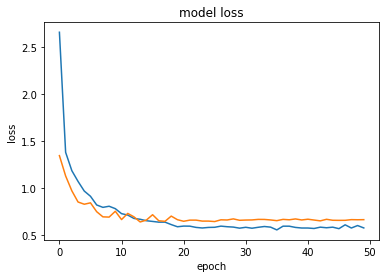

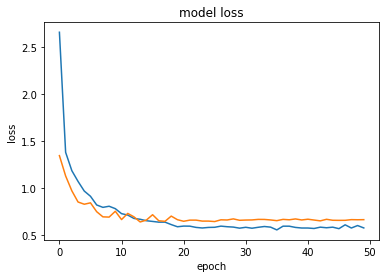

In [15]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [16]:
#Evaluating the model
test_result=[]
q_est,r_est=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f_eval:
  test_list=json.load(f_eval)

for img in test_list:
  img_path=os.path.join(dataset_root,'images','real',img['filename'])
  img_arr=image.load_img(img_path,target_size=(299,299))
  x=image.img_to_array(img_arr)
  x=preprocess_input(x)
  x=np.expand_dims(x,axis=0)
  output=model.predict(x)
  output=output.tolist()
  test_result.append({'filename':img['filename'],'q':output[:4],'r':output[4:]})
  q_est.append(output[0][:4])
  r_est.append(output[0][4:])
  print(output)


[[0.08568225800991058, 0.07686755061149597, 0.036857474595308304, -0.055088624358177185, 0.062264181673526764, 0.053731370717287064, 3.036977529525757]]
[[0.08568225800991058, 0.07686755061149597, 0.036857474595308304, -0.055088624358177185, 0.062264181673526764, 0.053731370717287064, 3.036977529525757]]
[[-0.2942650318145752, 0.10394446551799774, -0.04405135288834572, -0.09130121022462845, 0.03899755701422691, -0.15071018040180206, 3.413869857788086]]
[[-0.2942650318145752, 0.10394446551799774, -0.04405135288834572, -0.09130121022462845, 0.03899755701422691, -0.15071018040180206, 3.413869857788086]]
[[0.08134737610816956, 0.04018733277916908, -0.088424913585186, -0.08146484196186066, -0.4453805088996887, -0.24598000943660736, 4.721578598022461]]
[[0.08134737610816956, 0.04018733277916908, -0.088424913585186, -0.08146484196186066, -0.4453805088996887, -0.24598000943660736, 4.721578598022461]]
[[0.040433090180158615, -0.012583189643919468, -0.10285767912864685, -0.08099297434091568, 0.0

In [0]:
# img_path=os.path.join(dataset_root,'images','test','img000014.jpg')
# img_arr=image.load_img(img_path,target_size=(299,299))
# x=image.img_to_array(img_arr)
# x=preprocess_input(x)
# x=np.expand_dims(x,axis=0)
# output=model.predict(x)
# output=output.tolist()
# output

**Extracting r_gt and q_gt from real.json**

In [0]:
real_json=[]
q_gt,r_gt=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f:
  real_json=json.load(f)
for i in range(len(real_json)):
  q_gt.append(real_json[i]['q_vbs2tango'])
  r_gt.append(real_json[i]['r_Vo2To_vbs_true'])


**Calculating Orientation Score.**

Orientation score is the angle of the rotation, that aligns the estimated and ground truth orientations:

score(i)orientation=2⋅arccos(∣∣⟨q(i)est,q(i)gt⟩∣∣)

In [19]:
import math
score_orientation=0
bra_ket=[]
for i in range(len(real_json)):
  bra_ket.append(q_est[i][0]*q_gt[i][0]+q_est[i][1]*q_gt[i][1]+q_est[i][2]*q_gt[i][2]+q_est[i][3]*q_gt[i][3])
  
  
for i in range(len(real_json)):
  if bra_ket[i]<1:
    score_orientation+=2*math.acos(bra_ket[i])
score_orientation
#bra_ket



14.957223481712035

14.957223481712035

**Calculating Position Score**

The position score for image i is simply the 2-norm of the position error (difference of estimated and ground truth position vectors), normalized with the ground truth distance of the satellite:

score(i)position=∣∣r(i)gt−r(i)est∣∣2∣∣r(i)gt∣∣2

In [20]:
from numpy import linalg
score_position=0
for i in range(len(real_json)):
   score_position+=(abs(linalg.norm([r_gt[i]],2)-linalg.norm([r_est[i]],2))/linalg.norm([r_gt[i]],2))

#linalg.norm([r_gt[0]])
score_position

0.3112730431290028

0.3112730431290028

**Finally, the total score is the average of pose scores over all images of the test set:**

In [21]:
score=(score_orientation+score_position)/len(real_json)
score

3.0536993049682075

3.0536993049682075